In [1]:
import numpy as np
from math import exp,sqrt
import math
from scipy.constants import h, c, hbar, u, e
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags, spdiags
from scipy.interpolate import splrep, splev
from scipy.integrate import romb, solve_ivp, odeint
from scipy.linalg import eigh
from scipy.optimize import root,minimize
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def V(x,f,alpha,D_e,x_e):
    """x:Angstrom.  alpha:1/Angstrom   D_e:eV"""
    return f * x + D_e*(np.exp(-2*alpha*(x-x_e))-2*np.exp(-alpha*(x-x_e)))

In [5]:
# Now can solve up to the second excited CMES surface
def fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=None, gs_coef=None, ex1_coef=None,
                                 ntrial=100, eps=5e-3, bound=(0, 5), mass=1.0, debug=False):
    state = int(state)
    eps = abs(eps)
    # boundary
    if bound[1] < bound[0]:
        left = bound[1]
        right = bound[0]
    else:
        left = bound[0]
        right = bound[1]

    # number of grids
    N = int((right - left) / eps) + 1
    # make sure in the end there are 2**k + 1 points
    N = int(2 ** int(np.ceil(np.log2(N))) + 1)
    if debug:
        print(f'{N=}')
    # distance between points
    dx = float(right - left) / (N - 1)
    # x grids
    x = np.linspace(left, right, num=N)
    
    D_e=h*c*omega_e**2/(4*omega_chi)/e
    alpha=sqrt(2*mass*u*h*c*omega_chi/(hbar**2))*1e-10
    
    # solve for the ground state first
    diagonals = np.zeros((3, N))
    # off-diag
    diagonals[0, :] = -0.5 * hbar ** 2 * 1e20/e  / (mass * u) / dx**2
    # diag
    diagonals[1, :] = float(1) * hbar ** 2 *1e20 /e / (mass * u) / dx**2
    # in the end this is a symmetric matrix
    diagonals[2, 1:] = diagonals[0, :-1]
    xx = np.linspace(left, right, N)
    out1=np.exp(-2*alpha*(xx-x_e))
    out2=np.exp(-alpha*(xx-x_e))
    v_plt = D_e*(out1-2*out2)
    if state == 0:
        if init_f is None:
            init_f = 0.0
        def x_diff(f):
            # potential part
            diagonals_cp = np.copy(diagonals)
            diagonals_cp[1, :] += V(x, f, alpha, D_e, x_e)
            H = spdiags(diagonals_cp, [-1, 0, 1], N, N, format='csc')
            # solve Hc = ec
            v_f_plt = v_plt + f * xx
            ene, coef = eigsh(H, sigma=v_f_plt.min(), k=ntrial, which='LM')
            xExp = []
            true_e = []
            for i in range(ntrial):
                xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
                true_e.append(ene[i] - f.item(0) * xExp[-1])
            xExp = np.array(xExp)
            true_e = np.array(true_e)
            idx = np.argpartition(true_e, range(state + 2))
            if debug:
                print(f'{f=}, {xExp[idx[state]] - x_exp=}')# debug
                print(idx[state])
            return (xExp[idx[state]] - x_exp)
        sol = root(x_diff, init_f,method='df-sane', options={'fatol' : 1e-11})
        # potential part
        diagonals[1, :] += V(x, sol.x, alpha, D_e, x_e)
        H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
        # solve Hc = ec
        v_f_plt = v_plt + sol.x * xx
        ene, coef = eigsh(H, k=ntrial,sigma=v_f_plt.min(), which='LM')
        xExp = []
        true_e = []
        for i in range(ntrial):
            xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
            true_e.append(ene[i] - sol.x.item(0) * xExp[-1])
        xExp = np.array(xExp)
        true_e = np.array(true_e)
        idx = np.argpartition(true_e, range(3))
        return true_e[idx[0]], coef[:, idx[0]] / np.sqrt(romb(coef[:, idx[0]] ** 2, dx=dx)), \
               sol.x.item(0), xExp[idx[0]] - x_exp
    elif state == 1:
        if init_f is None:
            init_f = [0.0, 0.0]
        overlap_mat = np.outer(gs_coef, gs_coef)
        if debug:
            print(overlap_mat.shape)
        def x_diff(f):
            # potential part
            diagonals_cp = np.copy(diagonals)
            diagonals_cp[1, :] += V(x, f[0], alpha, D_e, x_e)
            H = spdiags(diagonals_cp, [-1, 0, 1], N, N, format='csc')
            # convert to a dense matrix
            H = H.toarray() + f[1] * overlap_mat
            # solve Hc = ec
            ene, coef = eigh(H, subset_by_index=[0, ntrial])
            xExp = []
            overlap = []
            true_e = []
            for i in range(ntrial):
                xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
                overlap.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
                true_e.append(ene[i] - f[0] * xExp[-1] - f[1] * overlap[-1])
            xExp = np.array(xExp)
            overlap = np.array(overlap)
            true_e = np.array(true_e)
            idx = np.argpartition(true_e, range(3))
            if debug:
                print(f'{f[0]=}, {xExp[idx[0]] - x_exp=}') # debug
                print(f'{f[1]=}, {overlap[idx[0]]=}') # debug
                print(idx[0])
            return [xExp[idx[0]] - x_exp, overlap[idx[0]]]
        sol = root(x_diff, init_f,method='df-sane', options={'fatol' : 1e-11})
        # potential part
        diagonals[1, :] += V(x, sol.x[0], alpha, D_e, x_e)
        H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
        # convert to a dense matrix
        H = H.toarray() + sol.x[1] * overlap_mat
        # solve Hc = ec
        ene, coef = eigh(H, subset_by_index=[0, ntrial])
        xExp = []
        overlap = []
        true_e = []
        for i in range(ntrial):
            xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
            overlap.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
            true_e.append(ene[i] - sol.x[0] * xExp[-1] - sol.x[1] * overlap[-1])
        xExp = np.array(xExp)
        overlap = np.array(overlap)
        true_e = np.array(true_e)
        idx = np.argpartition(true_e, range(3))
        return true_e[idx[0]], coef[:, idx[0]] / np.sqrt(romb(coef[:, idx[0]] ** 2, dx=dx)), \
            sol.x[0], sol.x[1], xExp[idx[0]] - x_exp, overlap[idx[0]]
    
    # the second excited CMES
    elif state == 2:
        if init_f is None:
            init_f = [0.0, 0.0, 0.0]
        overlap_mat_gs = np.outer(gs_coef, gs_coef)
        overlap_mat_ex = np.outer(ex1_coef, ex1_coef)
        if debug:
            print(overlap_mat_gs.shape, overlap_mat_ex.shape)
        def x_diff(f):
            # potential part
            diagonals_cp = np.copy(diagonals)
            diagonals_cp[1, :] += V(x, f[0], alpha, D_e, x_e)
            H = spdiags(diagonals_cp, [-1, 0, 1], N, N, format='csc')
            # convert to a dense matrix
            H = H.toarray() + f[1] * overlap_mat_gs + f[2]*overlap_mat_ex
            # solve Hc = ec
            ene, coef = eigh(H, subset_by_index=[0, ntrial])
            xExp = []
            overlap_gs = []
            overlap_ex=[]
            true_e = []
            for i in range(ntrial):
                xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
                overlap_gs.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
                overlap_ex.append(romb(ex1_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
                true_e.append(ene[i] - f[0] * xExp[-1] - f[1] * overlap_gs[-1] - f[2]*overlap_ex[-1])
            xExp = np.array(xExp)
            overlap_gs = np.array(overlap_gs)
            overlap_ex=np.array(overlap_ex)
            true_e = np.array(true_e)
            idx = np.argpartition(true_e, range(3))
#             idx[0]=0
            if debug:
                print(idx[0:3])
                print(f'{f[0]=}, {xExp[idx[0]] - x_exp=}') # debug
                print(f'{f[1]=}, {overlap_gs[idx[0]]=}') # debug
                print(f'{f[2]=}, {overlap_ex[idx[0]]=}') # debug
                print(idx[0])
            return [xExp[idx[0]] - x_exp, overlap_gs[idx[0]], overlap_ex[idx[0]]]
        sol = root(x_diff, init_f,method='df-sane', options={'fatol' : 1e-11})
        # potential part
        diagonals[1, :] += V(x, sol.x[0], alpha, D_e, x_e)
        H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
        # convert to a dense matrix
        H = H.toarray() + sol.x[1] * overlap_mat_gs + sol.x[2] * overlap_mat_ex
        # solve Hc = ec
        ene, coef = eigh(H, subset_by_index=[0, ntrial])
        xExp = []
        overlap_gs = []
        overlap_ex = []
        true_e = []
        for i in range(ntrial):
            xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
            overlap_gs.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
            overlap_ex.append(romb(ex1_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
            true_e.append(ene[i] - sol.x[0] * xExp[-1] - sol.x[1] * overlap_gs[-1] - sol.x[2] * overlap_ex[-1])
        xExp = np.array(xExp)
        overlap_gs = np.array(overlap_gs)
        overlap_ex = np.array(overlap_ex)
        true_e = np.array(true_e)
        idx = np.argpartition(true_e, range(3))
#         idx[0] = 0
        return true_e[idx[0]], sol.x[0], sol.x[1], sol.x[2], xExp[idx[0]] - x_exp, overlap_gs[idx[0]], overlap_ex[idx[0]], \
                xx, coef[:,idx[0]]
    else:
        raise ValueError('Only ground state, the 1st ex state, and the 2nd ex state are supported')

In [13]:
omega_e=350000
x_e=1.0
mass=1.0
omega_chi=omega_e*0.023
x_exp=1.14

e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=True, mass=mass)
print(e_gs, f0, error0)
e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[0,80], debug=True, mass=mass)
print(e_ex, f1, f2, error1, error2)
e_ex2, g0, g1, g2, error3, error4, error5, x, c_ex2 = fdm_constrained_dense_solver(omega_e, omega_chi, x_e, x_exp, state=2, gs_coef=c_gs, ex1_coef = c_ex, init_f=[0,50,50], debug=True, mass=mass)
print(e_ex2, g0, g1, g2, error3, error4)


N=1025
f=array(0), xExp[idx[state]] - x_exp=-0.12394926177669552
0
f=array(0.12394926), xExp[idx[state]] - x_exp=-0.12688946719625305
0
f=array(-5.2252878), xExp[idx[state]] - x_exp=0.8339303740279316
59
f=array(5.47318632), xExp[idx[state]] - x_exp=-0.21944123591674736
0
f=array(-0.41097444), xExp[idx[state]] - x_exp=-0.1137682667107962
0
f=array(-5.04906704), xExp[idx[state]] - x_exp=0.8071497414876192
58
f=array(4.22711815), xExp[idx[state]] - x_exp=-0.20208740356332033
0
f=array(-0.8747837), xExp[idx[state]] - x_exp=-0.10137235460901972
0
f=array(-4.6677629), xExp[idx[state]] - x_exp=0.6823810215885284
53
f=array(2.91819549), xExp[idx[state]] - x_exp=-0.18167824577169933
0
f=array(-1.25408162), xExp[idx[state]] - x_exp=-0.0903874703960037
1
f=array(-4.37507761), xExp[idx[state]] - x_exp=0.10460586580689246
50
f=array(-2.70079225), xExp[idx[state]] - x_exp=-0.03803627594881309
27
f=array(-3.14724923), xExp[idx[state]] - x_exp=-0.01642206042268235
34
f=array(-3.48645856), xExp[idx[st

f[0]=-2.3417120512581913, xExp[idx[0]] - x_exp=6.838973831690964e-14
f[1]=50.00000000006727, overlap_gs[idx[0]]=6.81417163414359e-13
f[2]=50.00000000979638, overlap_ex[idx[0]]=4.168207371365673e-11
25
-3.692846863763736 -2.3417120512581913 50.00000000006727 50.00000000979638 6.838973831690964e-14 6.81417163414359e-13


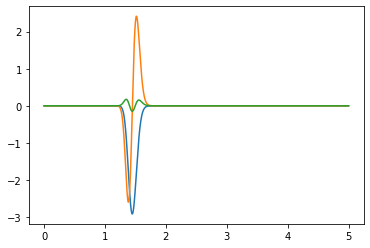

In [205]:
plt.plot(x,c_gs)
plt.plot(x,c_ex)
plt.plot(x,c_ex2)
plt.show()

In [4]:
# find the local minimum of the excited state CMES
def Morse_hessian_minima(omega_e,omega_chi,x_e,mass=1.0, debug_h=False,
                                 ntrial=100, eps=5e-3, bound=(0, 5)):
    D_e=h*c*omega_e**2/(4*omega_chi)/e
    alpha=sqrt(2*mass*u*h*c*omega_chi/(hbar**2))*1e-10
    
    def Morse_minima(position,potential):
        idx_position=np.argsort(position)
        position=position[idx_position]
        potential=potential[idx_position]

        tck=splrep(position, potential, s=0)
        x_start=position[0]
        x_end=position[-1]

        def first_D(x):
            return splev(x,tck,der=1)
        sol=root(first_D, x_e, method='lm', options={'ftol':1e-11})
        x0=sol.x.item(0)
        E0=splev(sol.x,tck).item(0)
        return x0,E0
    
    f0=0.0
    f1=0.0
    g0=0.0
    E_gs=np.array([])
    E_ex=np.array([])
    E_ex2=np.array([])
    
    x_scan=np.arange(x_e-0.05,x_e+0.05,0.01)
    
    for x_exp in x_scan:

        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=f0, debug=False, mass=mass)
        E_gs = np.append(E_gs, e_gs)
        if debug_h:
            print(x_exp)
            print(e_gs, f0, error0)

        e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[f1,80], debug=False, mass=mass)
        E_ex = np.append(E_ex, e_ex)
        if debug_h:
            print(e_ex, f1, f2, error1, error2)

        e_ex2, g0, g1, g2, error3, error4, error5, temp1, temp2 = fdm_constrained_dense_solver(omega_e, omega_chi, x_e, x_exp, state=2, gs_coef=c_gs, ex1_coef = c_ex, init_f=[g0,80,80], debug=False, mass=mass)
        E_ex2 = np.append(E_ex2, e_ex2)
        if debug_h:
            print(e_ex2, g0, g1, g2, error3, error4)

        
    x0,E0=Morse_minima(x_scan,E_gs)
    x1,E1=Morse_minima(x_scan,E_ex)
    x2,E2=Morse_minima(x_scan,E_ex2)

    
    return x0,E0, x1,E1, x2,E2, x_scan,E_gs,E_ex,E_ex2
        

In [6]:
# OH Morse parameters: CMES surfaces

omega_e=350000
omega_chi=omega_e*0.023
x_e=1.0

x_range=np.arange(0.8, 1.141, 0.02)
print(x_range)

f0=0.0
f1=0.0
g0=0.0
E_gs=np.array([])
E_ex=np.array([])
E_ex2=np.array([])
lines=[]

for x_exp in x_range:

    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False)
    E_gs = np.append(E_gs, e_gs)

    e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[f0,80], debug=False)
    E_ex = np.append(E_ex, e_ex)
    
    e_ex2, g0, g1, g2, error3, error4, error5, x_wf, c_ex = fdm_constrained_dense_solver(omega_e, omega_chi, x_e, x_exp, state=2, gs_coef=c_gs, ex1_coef = c_ex, init_f=[f1,80,80], debug=False)
    E_ex2 = np.append(E_ex2, e_ex2)
    
    lines.append([x_exp, e_gs, e_ex, e_ex2])
    print(lines[-1])
    

[0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06
 1.08 1.1  1.12 1.14]
[0.8, -2.9063617865015026, -2.1142170807484573, -1.3118698167916707]
[0.8200000000000001, -3.248691984203832, -2.4977856637347875, -1.7364831544821386]
[0.8400000000000001, -3.537691565685522, -2.8263315359685093, -2.1043742095275353]
[0.8600000000000001, -3.778886073049618, -3.1054575637797384, -2.421221491951949]
[0.8800000000000001, -3.9772938295032345, -3.340256582528819, -2.692190559060372]
[0.9000000000000001, -4.137470322512888, -3.53535604277752, -2.921978807792097]
[0.9200000000000002, -4.263548906959205, -3.69495888063473, -3.1148564914274792]
[0.9400000000000002, -4.359278008723804, -3.8228809301242648, -3.274704280581302]
[0.9600000000000002, -4.428055155664997, -3.922585181344351, -3.4050476669620684]
[0.9800000000000002, -4.472958143298335, -3.997213171971507, -3.5090884967993183]
[1.0000000000000002, -4.496773534560464, -4.049613764095865, -3.5897338876413873]
[1.0200000000000002

In [7]:
result=np.array(lines)
np.savetxt('omega_3500_x_gs_ex_ex2.txt', result)

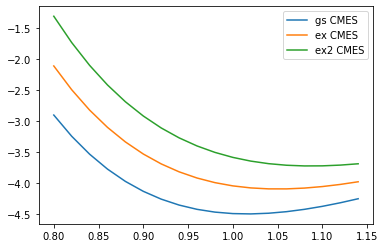

In [8]:
plt.plot(x_range, E_gs, label='gs CMES')
plt.plot(x_range, E_ex, label='ex CMES')
plt.plot(x_range, E_ex2, label='ex2 CMES')
plt.legend()
plt.show()

In [9]:
# scan omega_e
omega_range = np.array([2000, 2200, 2500, 2800, 3100, 3400, 3700, 4000])

chi=0.023
x_e=1.0
mass=1.0
gs_true=[]
ex1_true=[]
ex2_true=[]
lines=[]
CMES_gs=[]
CMES_ex=[]
CMES_ex2=[]
orth_ex=[]
coeff=[-1/560,8/315,-1/5,8/5,-205/72,8/5,-1/5,8/315,-1/560]
coeff=np.array(coeff)
Dx=np.arange(-0.02,0.021,0.005)
dx=0.005

for omega_e in omega_range:
    omega_e*=100
    omega_chi=omega_e*chi
    
    x0,E0, x1,E1, x2,E2, x_scan,E_gs_surface,E_ex_surface,E_ex2_surface=Morse_hessian_minima(omega_e, omega_chi, x_e, mass=mass)
    
    # ground state
    E_gs=np.array([])
    x_hessian_gs=x0+Dx
    for x_exp in x_hessian_gs:
        
        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False)
        E_gs = np.append(E_gs, e_gs)
        
    k_gs=sum(np.multiply(E_gs,coeff))/(dx**2)
    freq_gs=1/(2*math.pi)*math.sqrt(k_gs*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    CMES_gs.append(freq_gs)
    
    # 1st excited state
    E_ex=np.array([])
    x_hessian_ex=x1+Dx
    
    for x_exp in x_hessian_ex:
        
        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False)
        e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[0,80], debug=False)
        E_ex = np.append(E_ex, e_ex)
        
    k_ex=sum(np.multiply(E_ex,coeff))/(dx**2)
    freq_ex=1/(2*math.pi)*math.sqrt(k_ex*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    CMES_ex.append(freq_ex)
    
    # 2nd excited state
    E_ex2=np.array([])
    x_hessian_ex2=x2+Dx
    
    for x_exp in x_hessian_ex2:

        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False)
        e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[0,80], debug=False)
        e_ex2, g0, g1, g2, error3, error4, error5, x_wf, c_ex = fdm_constrained_dense_solver(omega_e, omega_chi, x_e, x_exp, state=2, gs_coef=c_gs, ex1_coef = c_ex, init_f=[0,80,80], debug=False)
        E_ex2 = np.append(E_ex2, e_ex2)
        
    k_ex2=sum(np.multiply(E_ex2,coeff))/(dx**2)
    freq_ex2=1/(2*math.pi)*math.sqrt(k_ex2*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    CMES_ex2.append(freq_ex2)
    
    lines.append([omega_e*1e-2,freq_gs,freq_ex,freq_ex2])
    print(lines[-1])

[2000.0, 1925.3637503052114, 1772.3698819129022, 1607.0281398401105]
[2200.0, 2117.9010193308663, 1949.689238814616, 1768.5120029912505]
[2500.0, 2406.7075626500114, 2215.6683983219923, 2010.8470468626756]
[2800.0, 2695.5137966022658, 2481.645086995237, 2253.2795844999478]
[3100.0, 2984.319689341224, 2747.617288669837, 2495.798462074102]
[3400.0, 3273.1252684466513, 3013.583711494921, 2738.3837220674386]
[3700.0, 3561.9305795828554, 3279.543675539984, 2981.024971302592]
[4000.0, 3850.7356806557605, 3545.4970960357855, 3223.711174822279]


In [10]:
result=np.array(lines)
np.savetxt('scan_omega_gs_ex_ex2.txt', result)

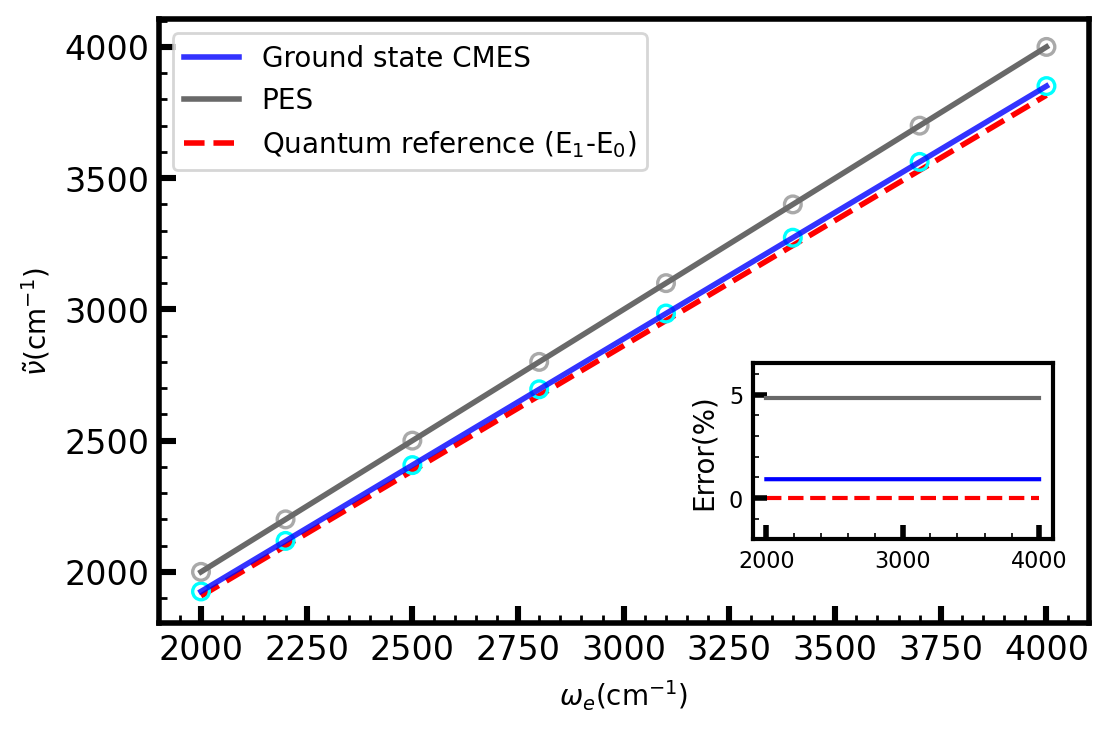

In [12]:
data=np.loadtxt('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/2_to_3_transition/scan_omega_gs_ex_ex2_E01_E12_E23.txt')

omega=data[:,0]
E01=data[:,4]
E12=data[:,5]
E23=data[:,6]
gs=data[:,1]
ex=data[:,2]
ex2=data[:,3]
gs_err=(data[:,1]-E01)/E01
ex_err=(data[:,2]-E12)/E12
ex2_err=(data[:,3]-E23)/E23
freq_cl=omega
freq_cl_0=(omega-E01)/E01
freq_cl_1=(omega-E12)/E12
freq_cl_2=(omega-E23)/E23

fig = plt.figure(1,dpi=200)
ax1 = fig.add_subplot(111)
# ax1.set_aspect(1./ax1.get_data_ratio())
plt.plot(omega,gs,label='Ground state CMES', color='blue', linewidth=2.0, alpha=0.8)
plt.scatter(omega, gs, color='none', edgecolor='cyan', linewidths=1.2,zorder=1)
plt.plot(omega,freq_cl,label='PES', color='dimgray', linewidth=2.0)
plt.scatter(omega, freq_cl, color='none', edgecolor='darkgray', linewidth=1.2)
plt.plot(omega,E01,label='Quantum reference (E$_1$-E$_0$)',linestyle='--',color='red', linewidth=2.0,zorder=0)
plt.legend()
plt.xlabel('$\omega_e$(cm$^{-1}$)')
plt.ylabel('$\~{\\nu}$(cm$^{-1}$)')
plt.minorticks_on()
plt.legend(loc='best')
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
ax1.tick_params(which='major', width=2.2, direction='in', labelsize=12, length=6)
ax1.tick_params(which='minor', width=1, direction='in', length=3)
ax1.spines['bottom'].set_linewidth(2.0)
ax1.spines['left'].set_linewidth(2.0)
ax1.spines['top'].set_linewidth(2.0)
ax1.spines['right'].set_linewidth(2.0)

fig2 = plt.axes([0.62,0.23,0.25,0.22])
plt.plot(omega,gs_err*100,label='gs', color='blue', linewidth=1.5)
plt.plot(omega,freq_cl_0*100,label='classical', color='dimgray', linewidth=1.5)
plt.hlines(0,2000,4000,linestyles='--',color='red', linewidth=1.5,zorder=0)
plt.ylabel('Error(%)',fontsize=10)
fig2.spines['bottom'].set_linewidth(1.5)
fig2.spines['left'].set_linewidth(1.5)
fig2.spines['right'].set_linewidth(1.5)
fig2.spines['top'].set_linewidth(1.5)
plt.minorticks_on()
fig2.tick_params(which='major', width=2.0, direction='in', labelsize=8, length=5)
fig2.tick_params(which='minor', direction='in')
fig2.set_ylim(-2, 6.5)

plt.show()

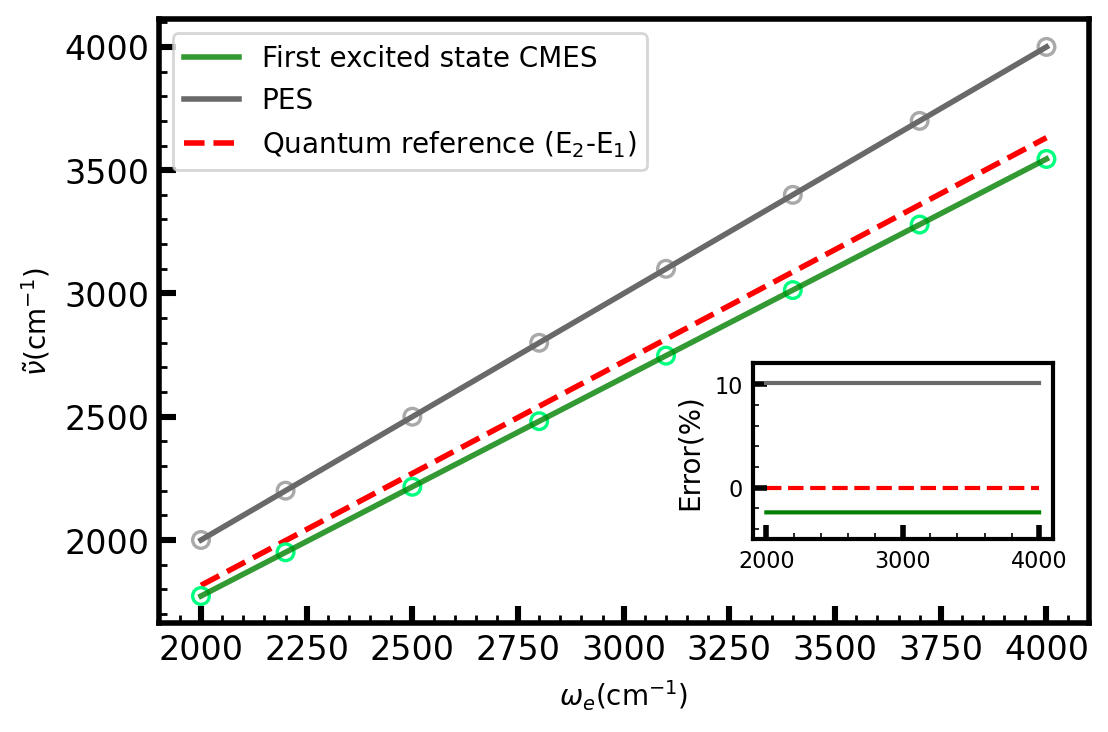

In [13]:
# state 1
fig = plt.figure(2,dpi=200)
ax1 = fig.add_subplot(111)
plt.plot(omega,ex,label='First excited state CMES', color='green', linewidth=2.0, alpha=0.8)
plt.scatter(omega, ex, color='none', edgecolor='springgreen', linewidths=1.2,zorder=1)
plt.plot(omega,freq_cl,label='PES', color='dimgray', linewidth=2.0)
plt.scatter(omega, freq_cl, color='none', edgecolor='darkgray', linewidth=1.2)
plt.plot(omega,E12,label='Quantum reference (E$_2$-E$_1$)',linestyle='--',color='red', linewidth=2.0,zorder=0)
plt.legend()
plt.xlabel('$\omega_e$(cm$^{-1}$)')
plt.ylabel('$\~{\\nu}$(cm$^{-1}$)')
plt.minorticks_on()
plt.legend(loc='best')
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
ax1.tick_params(which='major', width=2.2, direction='in', labelsize=12, length=6)
ax1.tick_params(which='minor', width=1, direction='in', length=3)
ax1.spines['bottom'].set_linewidth(2.0)
ax1.spines['left'].set_linewidth(2.0)
ax1.spines['top'].set_linewidth(2.0)
ax1.spines['right'].set_linewidth(2.0)

fig2 = plt.axes([0.62,0.23,0.25,0.22])
plt.plot(omega,ex_err*100,label='gs', color='green', linewidth=1.5)
plt.plot(omega,freq_cl_1*100,label='classical', color='dimgray', linewidth=1.5)
plt.hlines(0,2000,4000,linestyles='--',color='red', linewidth=1.5,zorder=0)
# plt.xlabel('$\omega_e$(cm$^{-1}$)',fontsize=7)
plt.ylabel('Error(%)',fontsize=10)
fig2.spines['bottom'].set_linewidth(1.5)
fig2.spines['left'].set_linewidth(1.5)
fig2.spines['right'].set_linewidth(1.5)
fig2.spines['top'].set_linewidth(1.5)
plt.minorticks_on()
fig2.tick_params(which='major', width=2.0, direction='in', labelsize=8, length=5)
fig2.tick_params(which='minor', direction='in')
fig2.set_ylim(-5, 12)

plt.show()

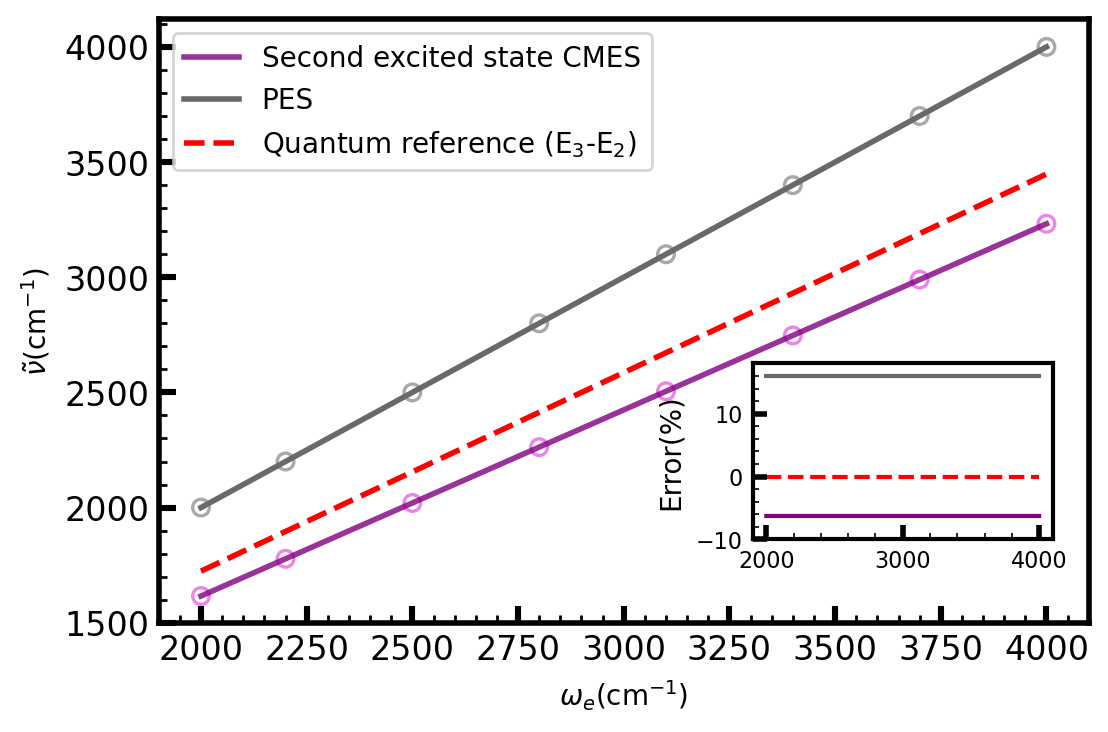

In [14]:
# state 2
fig = plt.figure(3,dpi=200)
ax1 = fig.add_subplot(111)
plt.plot(omega,ex2,label='Second excited state CMES', color='purple', linewidth=2.0, alpha=0.8)
plt.scatter(omega, ex2, color='none', edgecolor='violet', linewidths=1.2,zorder=1)
plt.plot(omega,freq_cl,label='PES', color='dimgray', linewidth=2.0)
plt.scatter(omega, freq_cl, color='none', edgecolor='darkgray', linewidth=1.2)
plt.plot(omega,E23,label='Quantum reference (E$_3$-E$_2$)',linestyle='--',color='red', linewidth=2.0,zorder=0)
plt.legend()
plt.xlabel('$\omega_e$(cm$^{-1}$)')
plt.ylabel('$\~{\\nu}$(cm$^{-1}$)')
plt.minorticks_on()
plt.legend(loc='best')
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
ax1.tick_params(which='major', width=2.2, direction='in', labelsize=12, length=6)
ax1.tick_params(which='minor', width=1, direction='in', length=3)
ax1.spines['bottom'].set_linewidth(2.0)
ax1.spines['left'].set_linewidth(2.0)
ax1.spines['top'].set_linewidth(2.0)
ax1.spines['right'].set_linewidth(2.0)

fig2 = plt.axes([0.62,0.23,0.25,0.22])
plt.plot(omega,ex2_err*100,label='gs', color='purple', linewidth=1.5)
plt.plot(omega,freq_cl_2*100,label='classical', color='dimgray', linewidth=1.5)
plt.hlines(0,2000,4000,linestyles='--',color='red', linewidth=1.5,zorder=0)
# plt.xlabel('$\omega_e$(cm$^{-1}$)',fontsize=7)
plt.ylabel('Error(%)',fontsize=10)
fig2.spines['bottom'].set_linewidth(1.5)
fig2.spines['left'].set_linewidth(1.5)
fig2.spines['right'].set_linewidth(1.5)
fig2.spines['top'].set_linewidth(1.5)
plt.minorticks_on()
fig2.tick_params(which='major', width=2.0, direction='in', labelsize=8, length=5)
fig2.tick_params(which='minor', direction='in')
fig2.set_ylim(-10, 18)

plt.show()

In [18]:
# calculate F/O/N frequencies
def Morse_hessian_orth(omega_e, omega_chi, x_e, mass):
    
    coeff=np.array([-1/560,8/315,-1/5,8/5,-205/72,8/5,-1/5,8/315,-1/560])
    dx=0.005
    Dx=np.arange(-4*dx, 4.1*dx, dx)
    
    x0,E0, x1,E1, x2,E2, x_scan,E_gs_surface,E_ex_surface,E_ex2_surface=Morse_hessian_minima(omega_e, omega_chi, x_e, mass=mass)
    
    # ground state
    E_gs=np.array([])
    x_hessian_gs=x0+Dx
    for x_exp in x_hessian_gs:
        
        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False, mass=mass)
        E_gs = np.append(E_gs, e_gs)
        
        
    k_gs=sum(np.multiply(E_gs,coeff))/(dx**2)
    freq_gs=1/(2*math.pi)*math.sqrt(k_gs*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    
    # 1st excited state
    E_ex=np.array([])
    x_hessian_ex=x1+Dx
    
    for x_exp in x_hessian_ex:
        
        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False, mass=mass)
        e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[0,80], debug=False, mass=mass)
        E_ex = np.append(E_ex, e_ex)
        
    k_ex=sum(np.multiply(E_ex,coeff))/(dx**2)
    freq_ex=1/(2*math.pi)*math.sqrt(k_ex*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    
    # 2nd excited state
    E_ex2=np.array([])
    x_hessian_ex2=x2+Dx
    
    for x_exp in x_hessian_ex2:

        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(omega_e,omega_chi,x_e, x_exp, state=0, init_f=0, debug=False, mass=mass)
        e_ex, c_ex, f1, f2, error1, error2=fdm_constrained_dense_solver(omega_e,omega_chi,x_e,x_exp,state=1,gs_coef=c_gs, init_f=[0,80], debug=False, mass=mass)
        e_ex2, g0, g1, g2, error3, error4, error5, x_wf, c_ex = fdm_constrained_dense_solver(omega_e, omega_chi, x_e, x_exp, state=2, gs_coef=c_gs, ex1_coef = c_ex, init_f=[0,80,80], debug=False, mass=mass)
        E_ex2 = np.append(E_ex2, e_ex2)
        
    k_ex2=sum(np.multiply(E_ex2,coeff))/(dx**2)
    freq_ex2=1/(2*math.pi)*math.sqrt(k_ex2*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1
    
    return [omega_e, omega_chi, x_e, mass, freq_gs, freq_ex, freq_ex2]

In [17]:
#F-F
omega_e=91664
x_e=1.41193
mass_F=19.0/2
omega_chi=1123.6

lines=[]
line=Morse_hessian_orth(omega_e, omega_chi, x_e, mass=mass_F)
lines.append(line)
print(lines[-1])

1.4192963623192025 -2.2614321980292877 1.4345151186202039 -2.152216265967498 1.4503980294133363 -2.0474228109485786
[91664, 1123.6, 1.41193, 9.5, 898.400995742386, 861.510923778553, 824.1919150204656]


In [19]:
#O-O
# when solving the minima, leave the upper bound as x_e+0.05 is enough
omega_e=158019
x_e=1.20752
mass=16.0/2
omega_chi=1198
line=Morse_hessian_orth(omega_e, omega_chi, x_e, mass)
lines.append(line)
print(lines[-1])

[158019, 1198, 1.20752, 8.0, 1560.7381798876258, 1521.5790332500264, 1482.1729679147193]


In [20]:
#N-N
# when solving the minima, leave the upper bound as x_e+0.05 is enough
omega_e=235857
x_e=1.09768
mass=14.0/2
omega_chi=1432.4
line=Morse_hessian_orth(omega_e, omega_chi, x_e, mass)
lines.append(line)
print(lines[-1])

[235857, 1432.4, 1.09768, 7.0, 2335.311003022541, 2288.5609458604076, 2241.600440446874]


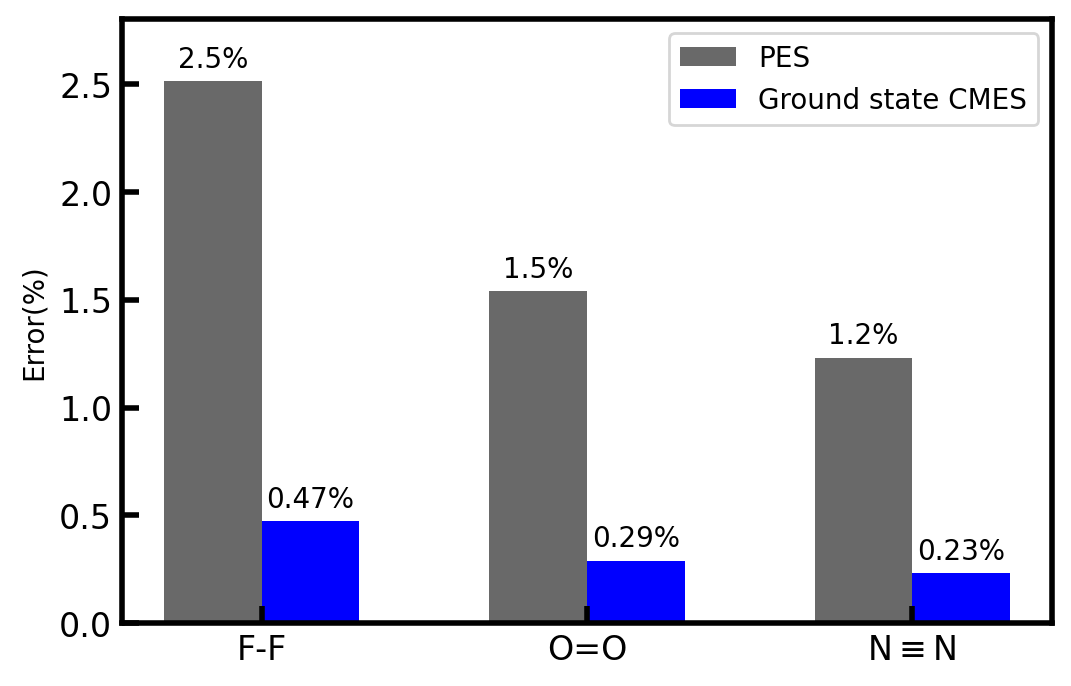

In [21]:
data=np.loadtxt('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/2_to_3_transition/FON_omega_chi_xe_mass_gs_ex_ex2_E01_E12_E23.txt')

xaxis=np.arange(1,4,1, dtype=int)
E01=data[:,7]
E21=data[:,8]
E32=data[:,9]
gs=(data[:,4]-E01)/E01
ex=(data[:,5]-E21)/E21
ex2=(data[:,6]-E32)/E32
freq_cl=data[:,0]/100
cl_0=(freq_cl-E01)/E01
cl_1=(freq_cl-E21)/E21
cl_2=(freq_cl-E32)/E32
names=['F-F','O=O','N$\equiv$N']

width=0.3
def height_annotate(rects,ax,width=0.3,fontsize=10):
    for rect in rects:
        height=rect.get_height()
        if height>=0:
            xytext=(0,3)
        else:
            xytext=(0,-10)
        ax.annotate('%.2g%%' % height,xy=(rect.get_x()+1/2*width,height),xytext=xytext,
                    textcoords='offset points',ha='center',va='bottom',fontsize=fontsize)
        
fig,ax=plt.subplots(dpi=200)
data_cl=ax.bar(xaxis-width/2,cl_0*100,width,label='PES',color='dimgray')
data_gs=ax.bar(xaxis+width/2,gs*100,width,label='Ground state CMES',color='blue')
plt.xticks(xaxis,names)
plt.ylabel('Error(%)')
plt.ylim(0,2.8)
plt.legend()
height_annotate(data_gs,ax)
height_annotate(data_cl,ax)
# plt.minorticks_on()
ax.tick_params(which='major', width=2.0, direction='in', labelsize=12, length=6)
ax.tick_params(which='minor', width=1, direction='in', length=3)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['top'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

plt.show()

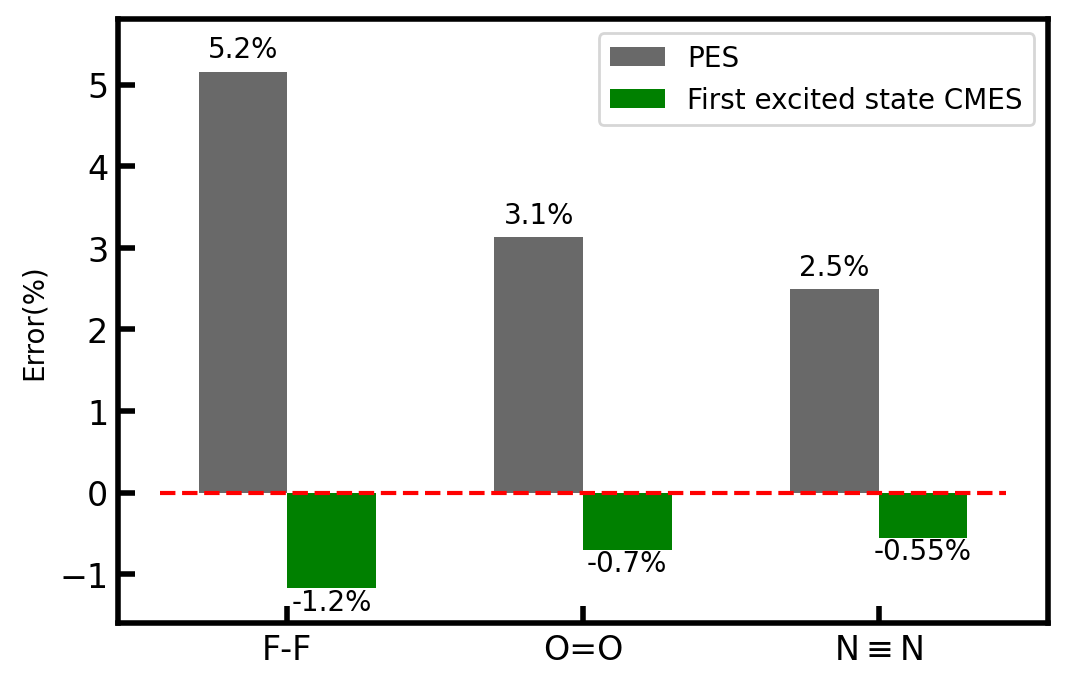

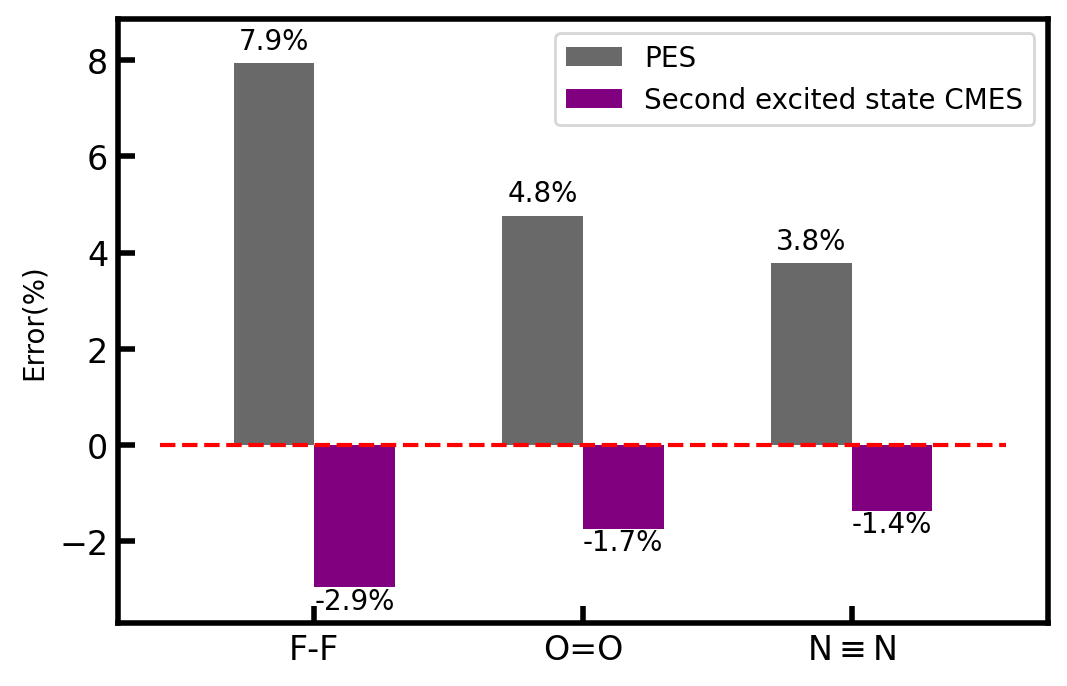

In [22]:
fig,ax1=plt.subplots(dpi=200)
data_cl1=ax1.bar(xaxis-width/2,cl_1*100,width,label='PES',color='dimgray')
data_ex=ax1.bar(xaxis+width/2,ex*100,width,label='First excited state CMES',color='green')
plt.xticks(xaxis,names)
plt.ylabel('Error(%)')
plt.ylim(-1.6,5.8)
left,right=ax1.get_xlim()
plt.hlines(0,left,right,linestyle='--',color='red')
plt.legend()
height_annotate(data_ex,ax1)
height_annotate(data_cl1,ax1)
# plt.minorticks_on()
ax1.tick_params(which='major', width=2.0, direction='in', labelsize=12, length=6)
# ax.tick_params(which='minor', width=1, direction='in', length=3)
ax1.spines['bottom'].set_linewidth(2.0)
ax1.spines['left'].set_linewidth(2.0)
ax1.spines['top'].set_linewidth(2.0)
ax1.spines['right'].set_linewidth(2.0)

plt.show()

fig,ax2=plt.subplots(dpi=200)
data_cl2=ax2.bar(xaxis-width/2,cl_2*100,width,label='PES',color='dimgray')
data_ex2=ax2.bar(xaxis+width/2,ex2*100,width,label='Second excited state CMES',color='purple')
plt.xticks(xaxis,names)
plt.ylabel('Error(%)')
plt.ylim(-3.7,8.85)
left,right=ax1.get_xlim()
plt.hlines(0,left,right,linestyle='--',color='red')
plt.legend()
height_annotate(data_ex2,ax2)
height_annotate(data_cl2,ax2)
# plt.minorticks_on()
ax2.tick_params(which='major', width=2.0, direction='in', labelsize=12, length=6)
# ax.tick_params(which='minor', width=1, direction='in', length=3)
ax2.spines['bottom'].set_linewidth(2.0)
ax2.spines['left'].set_linewidth(2.0)
ax2.spines['top'].set_linewidth(2.0)
ax2.spines['right'].set_linewidth(2.0)

plt.show()